In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()

# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 1 # 0.5 for Half

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


Using TensorFlow backend.


In [2]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model

import tensorflow as tf
import keras
import seaborn as sn
import pandas as pd
import numpy as np
import linecache
import sys
import h5py
import itertools
import matplotlib.pyplot as plt
import os
import pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [3]:
tf.__version__

'1.9.0'

In [4]:
train_path = '/data/danish/Data/Malimg-Color-25-Families/Malimg-Colorimage-train/'
test_path  = '/data/danish/Data/Malimg-Color-25-Families/Malimg-Colorimage-test/'

In [5]:
datagen_train = ImageDataGenerator(
      rescale=1./255#,
      #rotation_range=0.1,#180,
      #width_shift_range=0.1,
      #height_shift_range=0.1,
      #shear_range=0.1,
      #zoom_range=0.1,#[0.9, 1.5],
      #horizontal_flip=True,
      #vertical_flip=True,
      #fill_mode='nearest'
                )

datagen_test = ImageDataGenerator(rescale=1./255)


In [6]:
if False:
    save_to_dir='augmented_images/'
else:
    save_to_dir = None

In [7]:
input_shape=(299,299)
batch_size=32
save_fn='Deep_Learning_Model_for_Malimg_size_GrayScale='+str(input_shape[:])
save_fn

'Deep_Learning_Model_for_Malimg_size_GrayScale=(299, 299)'

In [8]:
generator_train = datagen_train.flow_from_directory(directory=train_path,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=42)


steps_train = generator_train.n/ batch_size
print("Steps for Training",steps_train)

cls_train = generator_train.classes
print(cls_train)
cls_names_train = list(generator_train.class_indices.keys())
print(cls_names_train)
num_cls_train = len(cls_names_train)
print("Number of Classes in Training Data",num_cls_train)

Found 6527 images belonging to 25 classes.
Steps for Training 203.96875
[ 0  0  0 ..., 24 24 24]
['AdialerC', 'AgentFYI', 'AllapleA', 'AllapleL', 'Aluerongen!J', 'AutorunK', 'C2LOPP', 'C2LOPgen!g', 'DialplatformB', 'DontovoA', 'Fakerean', 'Instantaccess', 'LolydaAA1', 'LolydaAA2', 'LolydaAA3', 'LolydaAT', 'Malexgen!J', 'ObfuscatorAD', 'Rbot!gen', 'SkintrimN', 'Swizzorgen!E', 'Swizzorgen!I', 'VBAT', 'WintrimBX', 'YunerA']
Number of Classes in Training Data 25


In [9]:
from sklearn.utils.class_weight import compute_class_weight
class_weight_train = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [10]:
#cls_names_train
class_labels = ['AdialerC','AgentFYI','AllapleA','AllapleL','Aluerongen!J','AutorunK','C2LOPP','C2LOPgen!g','DialplatformB','DontovoA',
 'Fakerean','Instantaccess','LolydaAA1','LolydaAA2','LolydaAA3','LolydaAT','Malexgen!J','ObfuscatorAD','Rbot!gen','SkintrimN',
 'Swizzorgen!E','Swizzorgen!I','VBAT','WintrimBX','YunerA']
list_fams = class_labels

In [11]:
class_weight_train

array([ 3.07152941,  3.22320988,  0.12649225,  0.23457323,  1.89188406,
        3.52810811,  2.55960784,  1.86485714,  2.12260163,  2.31044248,
        0.98150376,  0.86737542,  1.75221477,  2.0396875 ,  3.03581395,
        2.35207207,  2.74821053,  2.63717172,  2.37345455,  4.66214286,
        2.93348315,  2.83782609,  0.91607018,  3.89671642,  0.46621429])

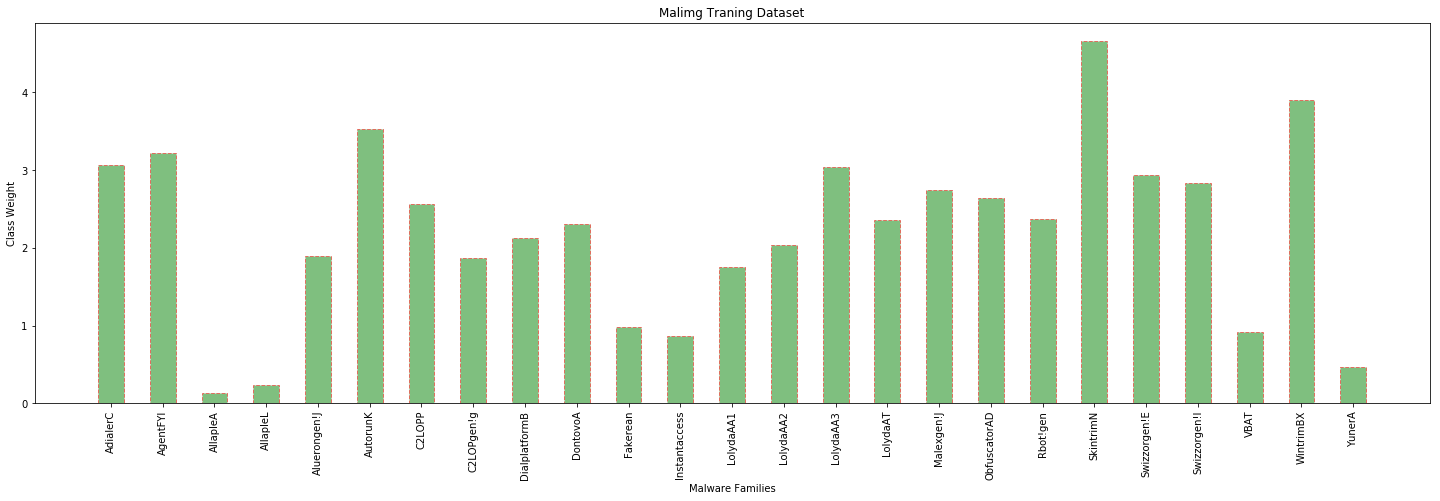

In [12]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = class_weight_train#[10,8,6,4,2,1]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Class Weight')
plt.title('Malimg Traning Dataset')
 
plt.show()

In [13]:
generator_test = datagen_test.flow_from_directory(directory=test_path,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=42)

steps_test = generator_test.n / batch_size
steps_test
print("Steps for Test",steps_test)

cls_test = generator_test.classes
print(cls_test)
cls_names_test = list(generator_test.class_indices.keys())
print(cls_names_test)
num_cls_test = len(cls_names_test)
print("Number of Classes in Test Data",num_cls_test)

Found 2812 images belonging to 25 classes.
Steps for Test 87.875
[ 0  0  0 ..., 24 24 24]
['AdialerC', 'AgentFYI', 'AllapleA', 'AllapleL', 'Aluerongen!J', 'AutorunK', 'C2LOPP', 'C2LOPgen!g', 'DialplatformB', 'DontovoA', 'Fakerean', 'Instantaccess', 'LolydaAA1', 'LolydaAA2', 'LolydaAA3', 'LolydaAT', 'Malexgen!J', 'ObfuscatorAD', 'Rbot!gen', 'SkintrimN', 'Swizzorgen!E', 'Swizzorgen!I', 'VBAT', 'WintrimBX', 'YunerA']
Number of Classes in Test Data 25


In [14]:
class_dictionary_test = generator_test.class_indices
class_dictionary_test

{'AdialerC': 0,
 'AgentFYI': 1,
 'AllapleA': 2,
 'AllapleL': 3,
 'Aluerongen!J': 4,
 'AutorunK': 5,
 'C2LOPP': 6,
 'C2LOPgen!g': 7,
 'DialplatformB': 8,
 'DontovoA': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'LolydaAA1': 12,
 'LolydaAA2': 13,
 'LolydaAA3': 14,
 'LolydaAT': 15,
 'Malexgen!J': 16,
 'ObfuscatorAD': 17,
 'Rbot!gen': 18,
 'SkintrimN': 19,
 'Swizzorgen!E': 20,
 'Swizzorgen!I': 21,
 'VBAT': 22,
 'WintrimBX': 23,
 'YunerA': 24}

In [15]:
from sklearn.utils.class_weight import compute_class_weight
class_weight_test = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_test),
                                    y=cls_test)

In [16]:
class_weight_test

array([ 3.04      ,  3.21371429,  0.12709605,  0.23531381,  1.87466667,
        3.515     ,  2.55636364,  1.87466667,  2.08296296,  2.2955102 ,
        0.97808696,  0.86523077,  1.7575    ,  2.00857143,  3.04      ,
        2.34333333,  2.74341463,  2.61581395,  2.34333333,  4.68666667,
        2.88410256,  2.812     ,  0.91447154,  3.74933333,  0.46866667])

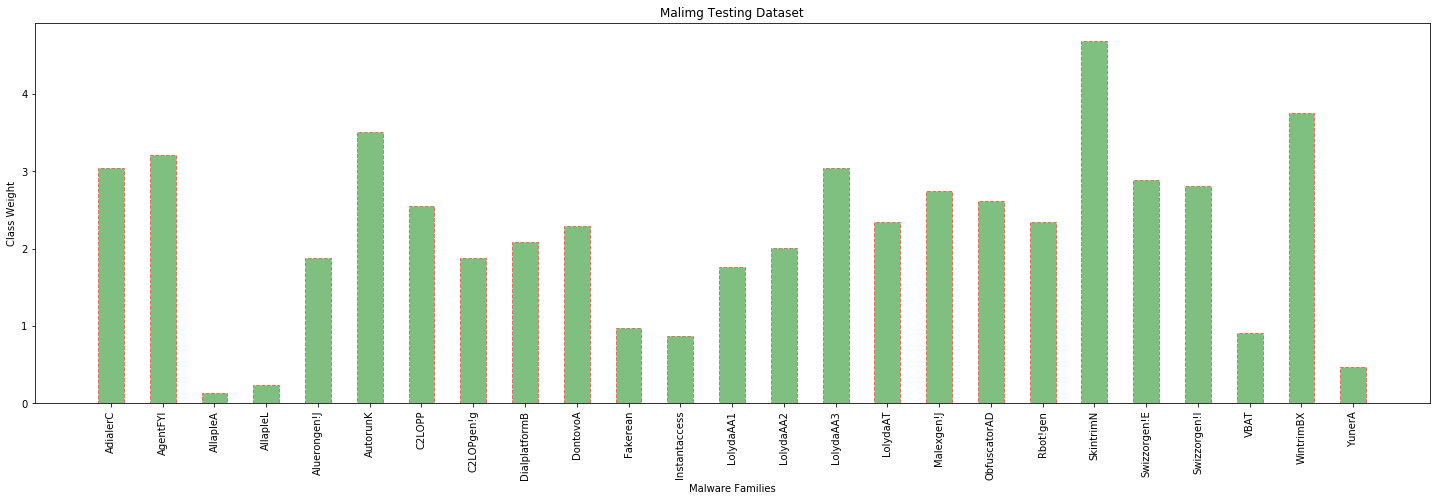

In [17]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = class_weight_test#[10,8,6,4,2,1]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Class Weight')
plt.title('Malimg Testing Dataset')
 
plt.show()

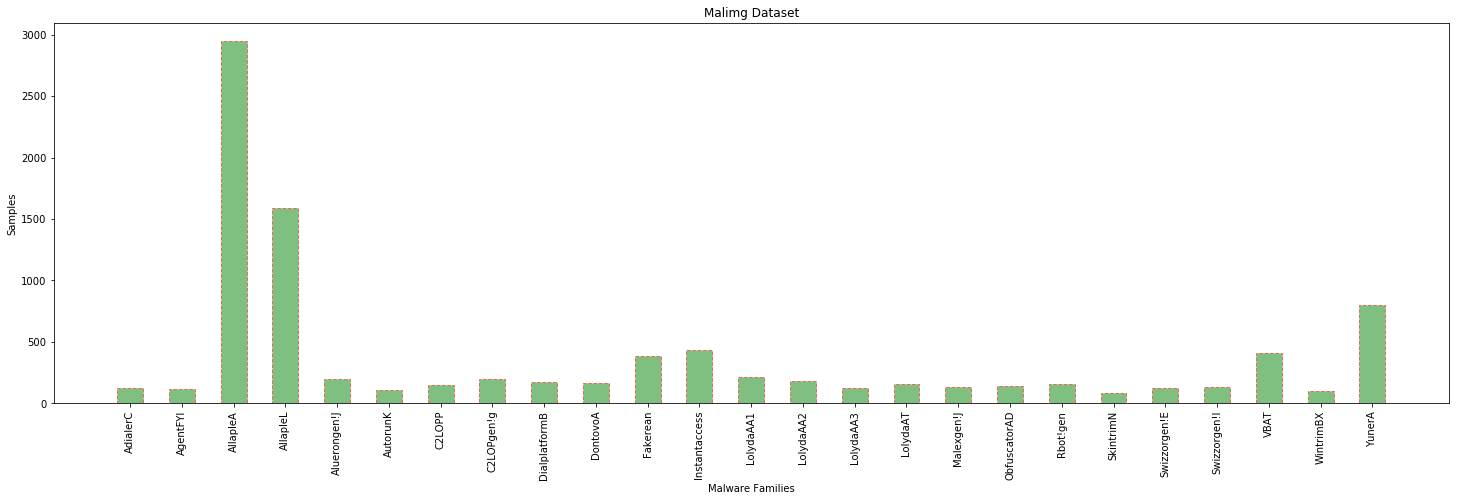

In [18]:
objects = class_labels#class_dictionary_train#cls_names_train#('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
y_pos = np.arange(len(objects))
performance = [122,116,2949,1591,198,106,146,200,177,162,381,431,213,184,123,159,136,142,158,80,128,132,408,97,800]
plt.figure(figsize = (25,7))
plt.bar(y_pos, performance, align='center', alpha=0.5, color='g', linestyle='--', width=0.5, edgecolor='r', )
plt.xticks(y_pos, objects, rotation='vertical')
plt.xlabel('Malware Families')
plt.ylabel('Samples')
plt.title('Malimg Dataset')
 
plt.show()

In [20]:
model = keras.applications.inception_v3.InceptionV3()

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [22]:
transfer_layer = model.get_layer('avg_pool')

In [23]:
transfer_layer.output

<tf.Tensor 'avg_pool/Mean:0' shape=(?, 2048) dtype=float32>

In [24]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [25]:
conv_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [26]:
# Start a new Keras Sequential model.
model = Sequential()

# Add the convolutional part of the VGG16 model from above.
model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
#model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
#model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
model.add(Dropout(0.5))

# Add the final layer for the actual classification.
model.add(Dense(num_cls_train, activation='softmax'))

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 2048)              21802784  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                51225     
Total params: 21,854,009
Trainable params: 21,819,577
Non-trainable params: 34,432
_________________________________________________________________


In [28]:

#model.load_weights('Deep_Learning_Model_for_Malimg_size=(192, 192)_Weights.hdf5')
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
epochs =10
steps_per_epoch=steps_train

In [30]:
history = model.fit_generator(generator=generator_train,
                                epochs=epochs,
                                steps_per_epoch=steps_per_epoch,
                                validation_data=generator_test,
                                validation_steps=steps_test
                                )




Epoch 1/10
204/203 [==============================] - 204s 999ms/step - loss: 0.3198 - acc: 0.9174 - val_loss: 0.0568 - val_acc: 0.9783
Epoch 2/10
204/203 [==============================] - 165s 807ms/step - loss: 0.0484 - acc: 0.9844 - val_loss: 0.0407 - val_acc: 0.9861
Epoch 3/10
204/203 [==============================] - 163s 797ms/step - loss: 0.0277 - acc: 0.9906 - val_loss: 0.0458 - val_acc: 0.9897
Epoch 4/10
204/203 [==============================] - 163s 798ms/step - loss: 0.0133 - acc: 0.9966 - val_loss: 0.0362 - val_acc: 0.9883
Epoch 5/10
204/203 [==============================] - 164s 806ms/step - loss: 0.0108 - acc: 0.9971 - val_loss: 0.0385 - val_acc: 0.9897
Epoch 6/10
204/203 [==============================] - 170s 833ms/step - loss: 0.0121 - acc: 0.9965 - val_loss: 0.0443 - val_acc: 0.9883
Epoch 7/10
204/203 [==============================] - 164s 806ms/step - loss: 0.0387 - acc: 0.9894 - val_loss: 0.0420 - val_acc: 0.9911
Epoch 8/10
204/203 [============================

In [36]:
model.save("InceptionV3-Color(Dropout).h5")

In [41]:
#####################################
# write Traning History to a file
output = open("InceptionV3-Color-History(Dropout).pkl", 'wb')
pickle.dump(history.history, output)
output.close()
#####################################

In [19]:
from keras.models import load_model
model = load_model('InceptionV3-Color(Dropout).h5')

In [20]:
sample = generator_test[85][0][0]
print(np.array(sample).shape)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

#sample = np.array(sample)

(299, 299, 3)
(1, 299, 299, 3)


In [28]:

cls_pred = model.predict(sample, verbose=1)#, steps_test, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)


1/1 [==============================] - 0s 32ms/step


In [42]:

# read Traning History back from the file
pkl_file = open("InceptionV3-Color-History(Dropout).pkl", 'rb')
history = pickle.load(pkl_file)
pkl_file.close()

In [43]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history) 

csv_file = 'InceptionV3-Color-History(Dropout).csv'
with open(csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [37]:
#scores = model.evaluate(X[test], Y[test], verbose=0)
#model.load_weights('Model_VGG16_Malimg_RGB_Trained_(229, 229)_Epochs=100_Model_Traning_Testing_Weights.hdf5')
scores = model.evaluate_generator(generator_test, verbose=1)# steps_test, max_queue_size=10, workers=1, use_multiprocessing=False,verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

88/88 [==============================] - 28s 323ms/step
acc: 98.65%


In [39]:
cls_pred = model.predict_generator(generator_test, verbose=1)#, steps_test, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)

88/88 [==============================] - 28s 313ms/step


In [44]:
cls_pred = np.argmax(cls_pred, axis=1)

In [45]:
y_test = cls_test = generator_test.classes

from pycm import ConfusionMatrix
CM_IMCFN = ConfusionMatrix(y_test,cls_pred)
file = open('CM-InceptionV3-Color(Dropout).pkl', 'wb')
pickle.dump(CM_IMCFN, file)
file.close()

In [46]:
# write Traning History to a file
file = open('CM-InceptionV3-Color(Dropout).pkl', 'rb')
CM_IMCFN = pickle.load(file)
file.close()

In [47]:
CM_IMCFN.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.99892
F1 Macro                                                          0.96587
Kappa                                                             0.98418
Overall ACC                                                       0.98649
PPV Macro                                                         0.96704
SOA1(Landis & Koch)                                               Almost Perfect
TPR Macro                                                         0.96794
Zero-one Loss                                                     38

Class Statistics :

Classes                                                           0             1             10            11            12            13            14            15            16            17            18            19            2             20            21            22            23            24            3             4             5             6 

/home/danish/anaconda3/envs/tf/lib/python3.6/site-packages/pycm/pycm_obj.py:167: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
The save_csv method can be used to save the confusion matrix in csv format and have a better demonstration of it.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [48]:
CM_IMCFN.save_csv("CM-InceptionV3-Color(Dropout)",address=True)

{'Status': True,
 'Message': '/data/danish/ImgProPython/TensorFlow-Tutorials/Computer-Networks-(CCF-B)/InceptionV3-Color/CM-InceptionV3-Color(Dropout).csv'}

In [49]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average=None)

print("All Classes")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

All Classes
Precision:  [ 1.          1.          1.          1.          0.96774194  1.
  0.97727273  0.98214286  1.          1.          1.          1.
  0.98461538  1.          1.          1.          1.          1.          1.
  1.          0.59649123  0.7         1.          0.96774194  1.        ]
Recall:  [ 1.          1.          1.          1.          1.          1.
  0.97727273  0.91666667  1.          1.          0.9826087   1.          1.
  0.98214286  1.          1.          0.97560976  1.          1.          1.
  0.87179487  0.525       0.96747967  1.          1.        ]
F1 score:  [ 1.          1.          1.          1.          0.98360656  1.
  0.97727273  0.94827586  1.          1.          0.99122807  1.
  0.99224806  0.99099099  1.          1.          0.98765432  1.          1.
  1.          0.70833333  0.6         0.98347107  0.98360656  1.        ]
CPU times: user 10.2 ms, sys: 4.6 ms, total: 14.8 ms
Wall time: 20.8 ms


In [50]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='micro')

print("Micro")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

Micro
Precision:  0.986486486486
Recall:  0.986486486486
F1 score:  0.986486486486
CPU times: user 5.76 ms, sys: 0 ns, total: 5.76 ms
Wall time: 9.89 ms


In [51]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='macro')

print("Macro")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

Macro
Precision:  0.967040242723
Recall:  0.967943009977
F1 score:  0.965867502239
CPU times: user 6.13 ms, sys: 50 µs, total: 6.18 ms
Wall time: 5.77 ms


In [52]:
%%time
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
cls_true = cls_test = generator_test.classes
accuracy = accuracy_score(cls_true, cls_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(cls_true, cls_pred, average='weighted')

print("weighted")
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1_score)

weighted
Precision:  0.988017029919
Recall:  0.986486486486
F1 score:  0.986663410644
CPU times: user 5.81 ms, sys: 0 ns, total: 5.81 ms
Wall time: 5.92 ms


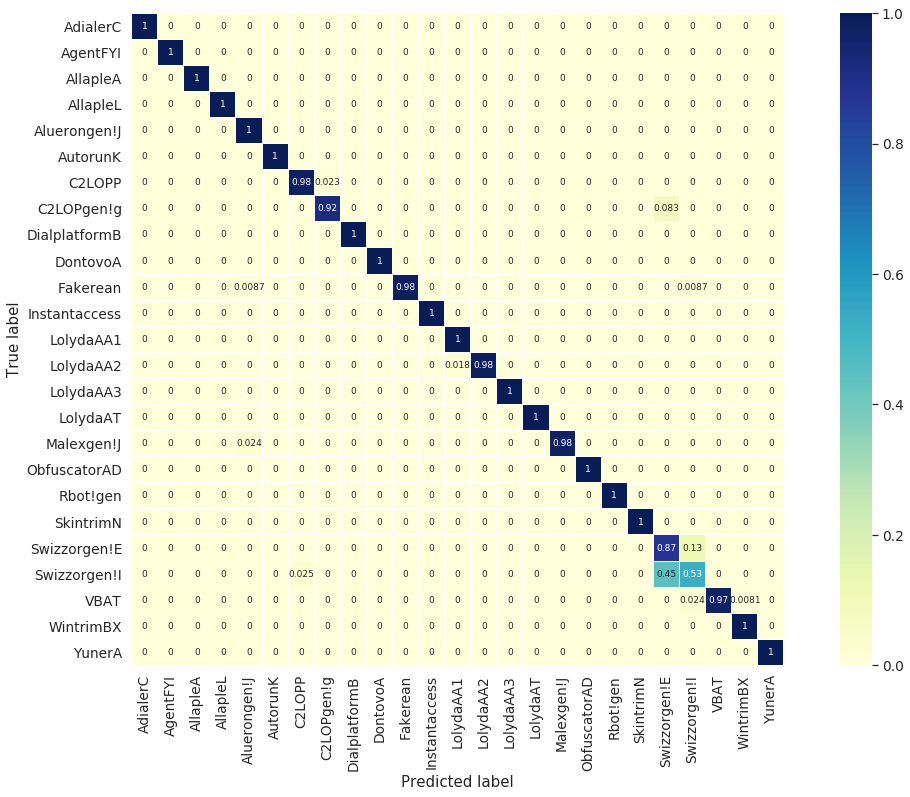

In [61]:
def plot_confusion_matrix():
    

    cm = confusion_matrix(cls_test, cls_pred)
    
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    
    figure = plt.gcf()
    figure.set_size_inches(20, 12)
    sn.set(font_scale=1.25)
    hm = sn.heatmap(cm, cmap= "YlGnBu" ,cbar=True, annot=True, square=True,
                 annot_kws={'size': 9}, linewidth = 0.01,
                 yticklabels=list_fams, xticklabels=list_fams)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.savefig('Ensemble-YlGnBu.png', bbox_inches='tight')
    plt.show()
    
plot_confusion_matrix()